In [ ]:
# !pip uninstall -y numpy scikit-learn
!pip install numpy==1.26.4
!pip install scikit-learn==1.2.2
!pip install cebra==0.4.0
!pip install git+https://github.com/NeuralAnalysis/PyalData.git

  Cloning https://github.com/NeuralAnalysis/PyalData.git to /tmp/pip-req-build-19x72bw3
  Running command git clone --filter=blob:none --quiet https://github.com/NeuralAnalysis/PyalData.git /tmp/pip-req-build-19x72bw3
  Resolved https://github.com/NeuralAnalysis/PyalData.git to commit 3c0458c6d4b3ee688d64f9e594327afde17f00a6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



=== Processing Chewie_CO_20161021.mat ===

=== Fold 0 ===
pca_vel_lstm: R² = 0.979, MAE = 0.331


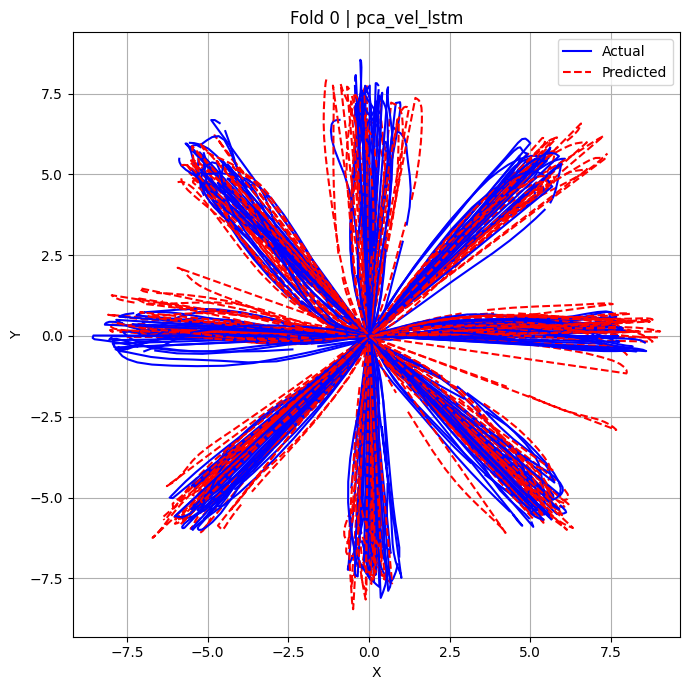

cebra_vel_lstm: R² = 0.938, MAE = 0.545


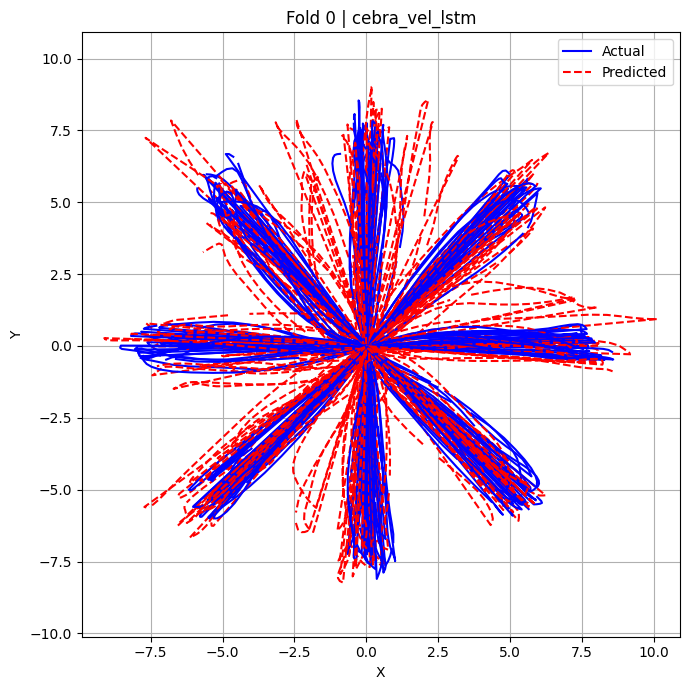

Fold 0 | baseline_avg_path
baseline_avg_path: R² = 0.990, MAE = 0.250


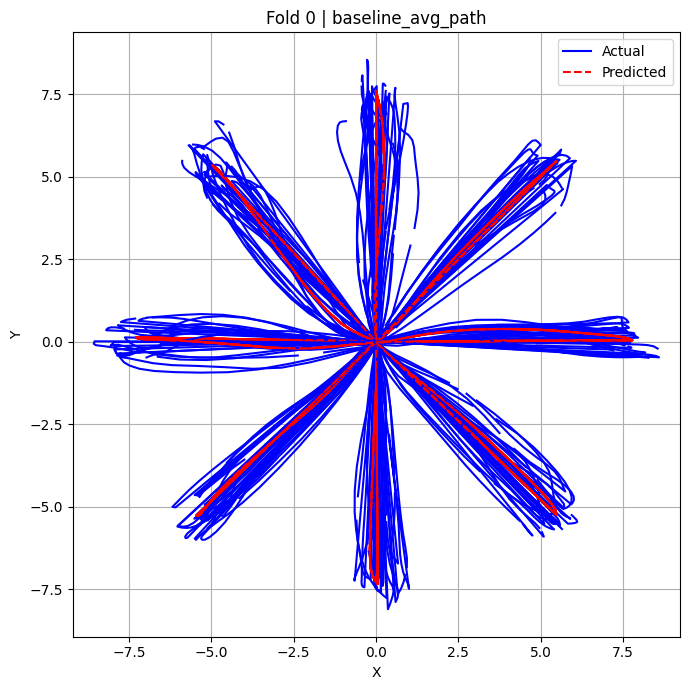


=== Fold 1 ===
pca_vel_lstm: R² = 0.972, MAE = 0.361


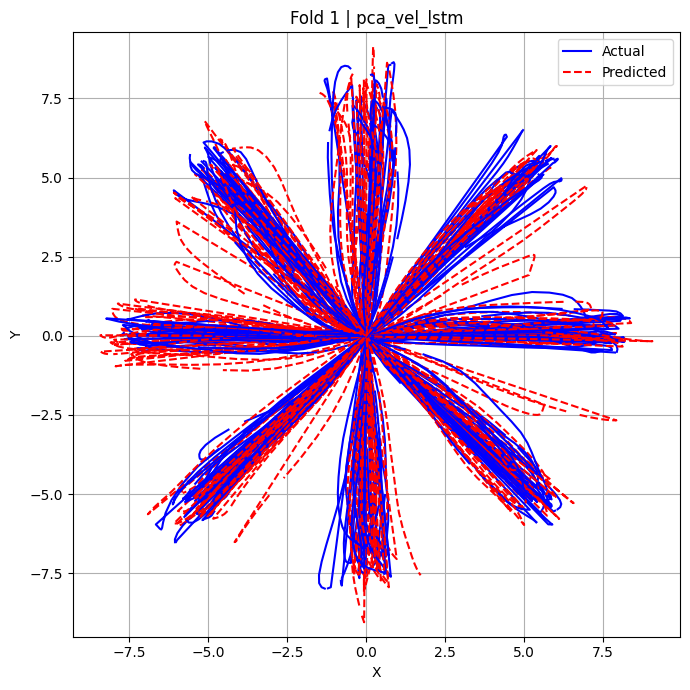

cebra_vel_lstm: R² = 0.831, MAE = 0.903


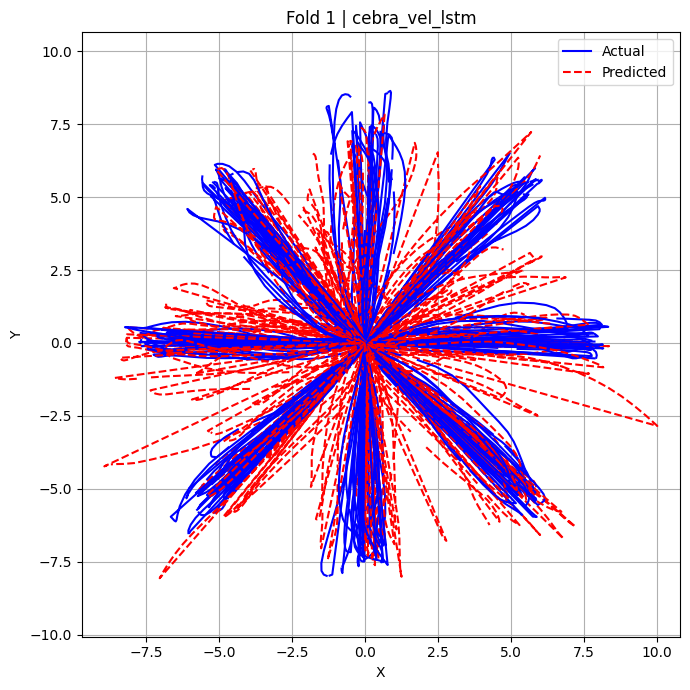

Fold 1 | baseline_avg_path
baseline_avg_path: R² = 0.988, MAE = 0.263


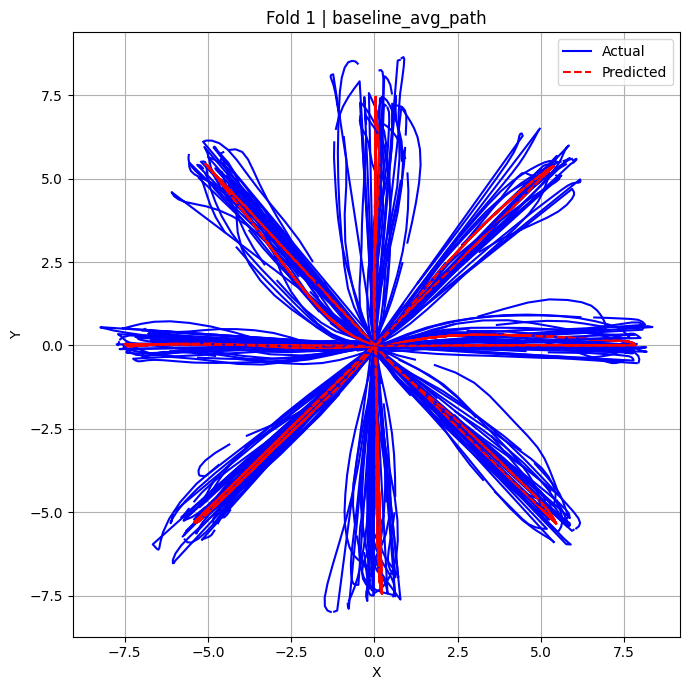


=== SUMMARY ===
                               r2       mae
embedding         model                    
baseline_avg_path mean   0.989242  0.256836
cebra_vel         lstm   0.884645  0.723937
pca_vel           lstm   0.975369  0.346133


In [ ]:
# --- IMPORTS ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error
from cebra import CEBRA
from pyaldata import *
import warnings

warnings.filterwarnings("ignore")

# --- PARAMETERS ---
PCA_DIMS = 20
MAX_ITER = 5000
BIN_SIZE = 0.03
TRIAL_LEN = 20
PLOT_ALL_TRIALS = True
NUM_PLOT_TRIALS = 40
n_fold = 2
EPOCHS = 5000
BATCH_SIZE = 5096
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_FOLDER = "/content/drive/MyDrive/RAW"

# --- UTILITIES ---
def mat2df(mat_path):
    return mat2dataframe(mat_path, shift_idx_fields=True)

def preprocess_df(df):
    drop_cols = ["M1_lfp", "PMd_lfp", "M1_lfp_guide", "PMd_lfp_guide", "M1_unit_guide", "PMd_unit_guide"]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors="ignore")
    df["trial_id"] = np.arange(len(df))
    df = df.rename(columns={"tgtDir": "target_direction"})
    return df

def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25 * np.pi))) - 1

def integrate_velocity_to_position(vel, dt=BIN_SIZE):
    vel = np.array(vel)
    return np.cumsum(vel, axis=0) * dt

def plot_fixed_length_trials(y_test, y_pred, trial_length=20, num_trials=5, title=""):
    plt.figure(figsize=(7, 7))
    total_trials = len(y_test) // trial_length
    for i in range(min(num_trials, total_trials)):
        start = i * trial_length
        end = start + trial_length
        plt.plot(y_test[start:end, 0], y_test[start:end, 1], color='blue', label='Actual' if i == 0 else "")
        plt.plot(y_pred[start:end, 0], y_pred[start:end, 1], color='red', linestyle='--', label='Predicted' if i == 0 else "")
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- LSTM Model ---
class LSTMDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2, num_layers=3, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,  # dropout only applies if num_layers > 1
            batch_first=True
        )
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.out(out)


def train_lstm(X_train, y_train, input_dim, hidden_dim=64, lr=3e-4, num_layers=3, dropout=0.2):
    model = LSTMDecoder(input_dim, hidden_dim, output_dim=2, num_layers=num_layers, dropout=dropout).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                             torch.tensor(y_train, dtype=torch.float32))
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model.train()
    for epoch in range(EPOCHS):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
    return model


def predict_lstm(model, X_seq):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(DEVICE)
        return model(X_tensor).cpu().numpy()

# --- MAIN LOGIC ---
filename = "Chewie_CO_20161021.mat"
file_path = os.path.join(DATA_FOLDER, filename)
print(f"\n=== Processing {filename} ===")
results = []

df = mat2df(file_path)
df = preprocess_df(df)
td = df.copy()
td = remove_low_firing_neurons(td, "M1_spikes", 5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)
td = transform_signal(td, "M1_spikes", 'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")
td = add_firing_rates(td, 'smooth')
td = select_trials(td, "result == 'R'")
td = restrict_to_interval(td, "idx_movement_on", end_point_name=None, rel_start=0, rel_end=TRIAL_LEN)
td = subtract_cross_condition_mean(td)
td["target_id"] = td.apply(get_target_id, axis=1)
td["hand_pos"] = td["vel"].apply(integrate_velocity_to_position)

target_ids = td["target_id"].values
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(np.arange(len(td)), target_ids)):
    print(f"\n=== Fold {fold} ===")
    train_td = td.iloc[train_idx].copy()
    test_td = td.iloc[test_idx].copy()

    def extract_embeddings(td_train, td_test, method="pca"):
        def chunk(trials):
            return [trial["both_rates"] for _, trial in trials.iterrows()]
        if method == "pca":
            pca = PCA(n_components=PCA_DIMS)
            X = np.vstack(chunk(td_train))
            pca.fit(X)
            return ([pca.transform(x) for x in chunk(td_train)],
                    [pca.transform(x) for x in chunk(td_test)])
        elif method == "cebra":
            cebra = CEBRA(model_architecture='offset10-model', batch_size=4096,
                          learning_rate=3e-4, temperature=1, output_dimension=PCA_DIMS,
                          max_iterations=MAX_ITER, distance='cosine', conditional='time_delta',
                          device='cuda_if_available', verbose=False, time_offsets=10)
            X = np.vstack(chunk(td_train))
            y = np.vstack([trial["vel"] for _, trial in td_train.iterrows()])
            cebra.fit(X, y)
            def transform(trials):
                data = np.vstack(chunk(trials))
                embed = cebra.transform(data)
                idx = 0
                split = []
                for _, row in trials.iterrows():
                    T = row["both_rates"].shape[0]
                    split.append(embed[idx:idx+T])
                    idx += T
                return split
            return transform(td_train), transform(td_test)
        else:
            raise ValueError("Unknown method")

    train_pca, test_pca = extract_embeddings(train_td, test_td, "pca")
    train_cebra, test_cebra = extract_embeddings(train_td, test_td, "cebra")

    embedding_sets = {
        "pca_vel": (train_pca, test_pca),
        "cebra_vel": (train_cebra, test_cebra),
    }

    for name, (X_train_seq, X_test_seq) in embedding_sets.items():
        y_train_seq = [trial["vel"] for _, trial in train_td.iterrows()]
        y_test_seq = [trial["vel"] for _, trial in test_td.iterrows()]

        model = train_lstm(X_train_seq, y_train_seq, PCA_DIMS)
        y_pred_seq = predict_lstm(model, X_test_seq)

        y_test_flat = np.concatenate([integrate_velocity_to_position(y) for y in y_test_seq])
        y_pred_flat = np.concatenate([integrate_velocity_to_position(y) for y in y_pred_seq])

        r2 = r2_score(y_test_flat, y_pred_flat)
        mae = mean_absolute_error(y_test_flat, y_pred_flat)
        print(f"{name}_lstm: R² = {r2:.3f}, MAE = {mae:.3f}")
        results.append({"embedding": name, "model": "lstm", "fold": fold, "r2": r2, "mae": mae})

        plot_fixed_length_trials(
            y_test=y_test_flat,
            y_pred=y_pred_flat,
            trial_length=TRIAL_LEN,
            num_trials=len(y_test_flat) // TRIAL_LEN if PLOT_ALL_TRIALS else NUM_PLOT_TRIALS,
            title=f"Fold {fold} | {name}_lstm"
        )

    # --- BASELINE AVG PATH ---
    print(f"Fold {fold} | baseline_avg_path")
    direction_to_avg_path = {
        dir_id: np.mean(np.stack(train_td[train_td["target_id"] == dir_id]["hand_pos"].values), axis=0)
        for dir_id in np.unique(train_td["target_id"])
    }

    actual_paths, pred_paths = [], []
    for _, row in test_td.iterrows():
        actual_paths.append(row["hand_pos"])
        pred_paths.append(direction_to_avg_path[row["target_id"]])

    y_test = np.concatenate(actual_paths)
    y_pred = np.concatenate(pred_paths)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"baseline_avg_path: R² = {r2:.3f}, MAE = {mae:.3f}")
    results.append({"embedding": "baseline_avg_path", "model": "mean", "fold": fold, "r2": r2, "mae": mae})

    plot_fixed_length_trials(
        y_test=y_test,
        y_pred=y_pred,
        trial_length=TRIAL_LEN,
        num_trials=len(y_test_flat) // TRIAL_LEN if PLOT_ALL_TRIALS else NUM_PLOT_TRIALS,
        title=f"Fold {fold} | baseline_avg_path"
    )

# --- RESULTS ---
results_df = pd.DataFrame(results)
print("\n=== SUMMARY ===")
print(results_df.groupby(["embedding", "model"]).agg({"r2": "mean", "mae": "mean"}))